In [88]:
import cPickle as pickle
import sys
sys.path.append('/usr/app/frustum-pointnets/train/')
import provider
import numpy as np
import copy

In [89]:
data_path = '/usr/app/frustum-pointnets/train/detection_results_19022100.pickle'
with open(data_path, 'rb') as fp:
    ps_list = pickle.load(fp)
    segp_list = pickle.load(fp)
    center_list = pickle.load(fp)
    heading_cls_list = pickle.load(fp)
    heading_res_list = pickle.load(fp)
    size_cls_list = pickle.load(fp)
    size_res_list = pickle.load(fp)
    rot_angle_list = pickle.load(fp)
    score_list = pickle.load(fp)
    onehot_list = pickle.load(fp)
    obj_xyz_list = pickle.load(fp)
    ps_select_list = pickle.load(fp)

In [90]:
diff_obj_xyz_list = []
reldiff_obj_xyz_list = []
for idx in range(len(ps_list)):
    # deep copy data,
    # otherwise provider.from_prediction_to_label_format will cause bug.
    ps = np.copy(ps_list[idx])
    segp = np.copy(segp_list[idx])
    obj_xyz = np.copy(obj_xyz_list[idx])
    ps_select = np.copy(ps_select_list[idx])
    rot_angle = np.copy(rot_angle_list[idx])
    center = np.copy(center_list[idx])
    heading_cls = np.copy(heading_cls_list[idx])
    heading_res = np.copy(heading_res_list[idx])
    size_cls = size_cls_list[idx]
    size_res = np.copy(size_res_list[idx])

    # rotate point cloud (frustrum frame) to camera frame
    ps_select = provider.rotate_pc_along_y(ps_select, -rot_angle)
    # get box3d from prediction
    h,w,l,tx,ty,tz,ry = provider.from_prediction_to_label_format(center,
        heading_cls, heading_res,
        size_cls, size_res, rot_angle)
    # recover normalized obj_xyz_mask to camera frame
    obj_xyz_rcv = provider.recover_obj_xyz(obj_xyz, np.array([h,w,l,tx,ty,tz,ry]))
    # compute l1 norm
    diff_obj_xyz = np.abs(ps_select[:, :3] - obj_xyz_rcv)
    diff_obj_xyz_list.append(diff_obj_xyz)
    # compute relative diff
    reldiff_obj_xyz = diff_obj_xyz / np.array([l, h, w])
    reldiff_obj_xyz_list.append(reldiff_obj_xyz)
        
diff_obj_xyz_np = np.concatenate(diff_obj_xyz_list)
print("diff mean is {}".format(diff_obj_xyz_np.mean(axis=0)))
print("diff std is {}".format(diff_obj_xyz_np.std(axis=0)))
reldiff_obj_xyz_np = np.concatenate(reldiff_obj_xyz_list)
print("reldiff mean is {}".format(reldiff_obj_xyz_np.mean(axis=0)))
print("reldiff std is {}".format(reldiff_obj_xyz_np.std(axis=0)))

diff mean is [ 0.33240774  0.04750289  0.7354407 ]
diff std is [ 1.410474    0.07348201  3.63548161]
reldiff mean is [ 0.19329105  0.02923708  0.88598822]
reldiff std is [ 1.21172257  0.04535417  5.17459394]


In [118]:
from open3d import *
idx = 7
# deep copy data,
# otherwise provider.from_prediction_to_label_format will cause bug.
ps = np.copy(ps_list[idx])
segp = np.copy(segp_list[idx])
obj_xyz = np.copy(obj_xyz_list[idx])
ps_select = np.copy(ps_select_list[idx])
rot_angle = np.copy(rot_angle_list[idx])
center = np.copy(center_list[idx])
heading_cls = np.copy(heading_cls_list[idx])
heading_res = np.copy(heading_res_list[idx])
size_cls = size_cls_list[idx]
size_res = np.copy(size_res_list[idx])

# rotate point cloud (frustrum frame) to camera frame
ps_select = provider.rotate_pc_along_y(ps_select, -rot_angle)
# get box3d from prediction
h,w,l,tx,ty,tz,ry = provider.from_prediction_to_label_format(center,
    heading_cls, heading_res,
    size_cls, size_res, rot_angle)
# recover normalized obj_xyz_mask to camera frame
obj_xyz_rcv = provider.recover_obj_xyz(obj_xyz, np.array([h,w,l,tx,ty,tz,ry]))

print("idx is {}".format(idx))
print("bottom_center point is at{}".format(np.array([tx, ty, tz])))
print("box3d size is {}".format(np.array([l, h, w])))
diff = np.abs(obj_xyz_rcv - ps_select[:,:3])
print("Difference min is {}".format(diff.min(axis=0)))
print("Difference max is {}".format(diff.max(axis=0)))
print("Difference mean is {}".format(diff.mean(axis=0)))
print("Difference var is {}".format(diff.var(axis=0)))

print("ps_select shape is {}".format(ps_select.shape))
print("ps_select range is {} - {}".format(ps_select[:,:3].min(axis=0), ps_select[:, :3].max(axis=0)))
ps_select_pcd = PointCloud()
ps_select_pcd.points = Vector3dVector(ps_select[:, :3])
write_point_cloud("ps_select.pcd", ps_select_pcd)
print("obj_xyz_rcv shape is {}".format(obj_xyz_rcv.shape))
print("obj_xyz_rcv range is {} - {}".format(obj_xyz_rcv[:,:3].min(axis=0), obj_xyz_rcv[:, :3].max(axis=0)))
obj_xyz_rcv_pcd = PointCloud()
obj_xyz_rcv_pcd.points = Vector3dVector(obj_xyz_rcv[:, :3])
write_point_cloud("obj_xyz_rcv.pcd", obj_xyz_rcv_pcd)

idx is 7
bottom_center point is at[-12.84870049   1.77792457  38.20746868]
box3d size is [ 3.96438524  1.57525046  1.61603102]
Difference min is [ 0.00848348  0.00181751  0.50908585]
Difference max is [ 1.07018996  0.08230623  3.88193917]
Difference mean is [ 0.57792944  0.0363746   2.40597319]
Difference var is [  7.50588239e-02   6.26320553e-04   7.65345961e-01]
ps_select shape is (512, 4)
ps_select range is [-13.89975016   0.57533509  35.93048517] - [-10.98429474   1.22870445  37.34382546]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [-12.9924485    0.52505637  37.52573833] - [-11.91078357   1.25586905  39.83322883]


True

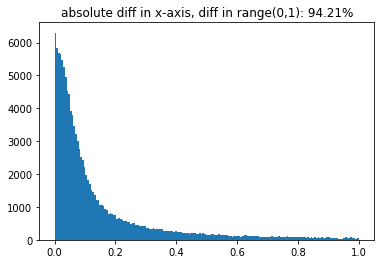

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
data = diff_obj_xyz_np[:,0]
plt.hist(data[::100], bins='auto', range=(0,1))
plt.title("absolute diff in x-axis, diff in range(0,1): {:.2f}%".format(data[data< 1.0].shape[0] / float(data.shape[0])*100))
plt.savefig("diff_x.png", dpi=300)

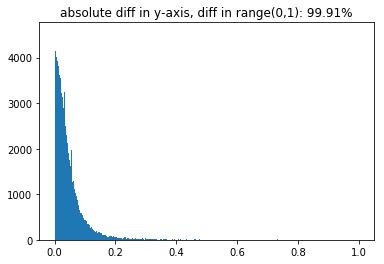

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
data = diff_obj_xyz_np[:,1]
plt.hist(data[::100], bins='auto', range=(0,1))
plt.title("absolute diff in y-axis, diff in range(0,1): {:.2f}%".format(data[data< 1.0].shape[0] / float(data.shape[0])*100))
plt.savefig("diff_y.png", dpi=300)

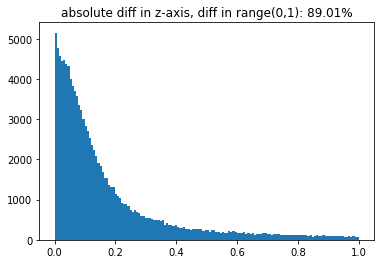

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline
data = diff_obj_xyz_np[:,2]
plt.hist(data[::100], bins='auto', range=(0,1))
plt.title("absolute diff in z-axis, diff in range(0,1): {:.2f}%".format(data[data< 1.0].shape[0] / float(data.shape[0])*100))
plt.savefig("diff_z.png", dpi=300)

tag: good_cases_0
idx: 2
bottom_center point is at[-15.6251629    2.17109271  38.29569466]
box3d size is [ 3.89488173  1.47570699  1.61253319]
Difference min is [ 0.0021184   0.0001694   0.00401801]
Difference max is [ 0.16046038  0.06132944  0.28033115]
Difference mean is [ 0.06044292  0.02264773  0.10631527]
Difference var is [ 0.00090638  0.00025501  0.00516401]
ps_select shape is (512, 4)
ps_select range is [-16.48406746   1.13009465  36.201966  ] - [-14.831517     2.12442517  39.79443032]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [-16.4232322    1.14384341  36.39211618] - [-14.80591102   2.09761186  39.80756337]

tag: good_cases_1
idx: 5
bottom_center point is at[ -8.482908     1.99931432  23.0270106 ]
box3d size is [ 1.01949613  1.80401589  0.77444163]
Difference min is [ 0.00011881  0.0014859   0.00019421]
Difference max is [ 0.09969703  0.05057063  0.05738278]
Difference mean is [ 0.01651472  0.0187505   0.0190969 ]
Difference var is [ 0.000387    0.00012772  0.00022253]
ps_select shape is (512, 4)
ps_select range is [ -8.93668469   0.24542885  22.75836494] - [ -8.11987105   1.92366827  23.47028796]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [ -8.85422481   0.29370376  22.71919556] - [ -8.20657244   1.9145658   23.41290518]

tag: bad_cases_0
idx: 4
bottom_center point is at[  8.65512526   2.13851269  10.00984054]
box3d size is [ 1.45500413  1.68737141  0.41609793]
Difference min is [ 2.54777158  0.28303933  2.72746433]
Difference max is [ 2.54777158  0.28303933  2.72746433]
Difference mean is [ 2.54777158  0.28303933  2.72746433]
Difference var is [  4.73513758e-28   8.90550006e-31   9.66354609e-30]
ps_select shape is (512, 4)
ps_select range is [ 6.25106836  1.49178588  7.45744877] - [ 6.25106836  1.49178588  7.45744877]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [  8.79883994   1.77482522  10.1849131 ] - [  8.79883994   1.77482522  10.1849131 ]

tag: good_cases_2
idx: 6
bottom_center point is at[ -2.55151338   1.2331104   31.64716634]
box3d size is [ 3.97592777  1.64042837  1.65280029]
Difference min is [ 0.00617902  0.00107937  0.00095108]
Difference max is [ 0.42846473  0.09777422  0.41276113]
Difference mean is [ 0.11670047  0.03795324  0.08439918]
Difference var is [ 0.00492045  0.00080913  0.00837206]
ps_select shape is (512, 4)
ps_select range is [ -3.90089015  -0.42913252  29.25664651] - [ -1.47356706   1.19212079  32.69324416]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [ -3.7138234   -0.33550389  29.6147072 ] - [ -1.35961429   1.1703053   32.9244169 ]

tag: bad_cases_2
idx: 7
bottom_center point is at[-12.84870049   1.77792457  38.20746868]
box3d size is [ 3.96438524  1.57525046  1.61603102]
Difference min is [ 0.00848348  0.00181751  0.50908585]
Difference max is [ 1.07018996  0.08230623  3.88193917]
Difference mean is [ 0.57792944  0.0363746   2.40597319]
Difference var is [  7.50588239e-02   6.26320553e-04   7.65345961e-01]
ps_select shape is (512, 4)
ps_select range is [-13.89975016   0.57533509  35.93048517] - [-10.98429474   1.22870445  37.34382546]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [-12.9924485    0.52505637  37.52573833] - [-11.91078357   1.25586905  39.83322883]

tag: good_cases_3
idx: 8
bottom_center point is at[-12.78741645   1.53752093  19.63151196]
box3d size is [ 4.02396991  1.45731481  1.61247178]
Difference min is [  4.90549294e-03   3.78212944e-05   8.72534802e-04]
Difference max is [ 0.33089908  0.06522356  0.44333683]
Difference mean is [ 0.18739852  0.01829631  0.07738992]
Difference var is [ 0.00485012  0.00021355  0.00446156]
ps_select shape is (512, 4)
ps_select range is [-14.30120169   0.1431158   18.20481929] - [-10.75105041   1.55384302  20.3011835 ]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [-14.39619992   0.17027488  18.30064347] - [-10.88634056   1.49108654  20.09813272]


tag: bad_cases_1
idx: 9
bottom_center point is at[ -2.84600552   0.9295987   47.98381071]
box3d size is [ 3.86567212  1.51755401  1.5789399 ]
Difference min is [ 0.05861224  0.00163184  0.48385248]
Difference max is [ 2.43801025  0.08862565  7.66804396]
Difference mean is [ 0.87013539  0.03801935  2.52863582]
Difference var is [  8.79475290e-01   1.21034317e-03   9.55864596e+00]
ps_select shape is (512, 4)
ps_select range is [ -2.82960911  -0.30855069  41.08646022] - [ -1.9611889    0.50034881  47.91032182]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [ -4.40358052  -0.27238385  47.34858394] - [ -2.24988504   0.49871696  48.75782804]

tag: good_cases_4
idx: 10
bottom_center point is at[  8.62216932   1.81021624  20.31637669]
box3d size is [ 3.61441431  1.562384    1.61624327]
Difference min is [ 0.00053975  0.00079948  0.0404582 ]
Difference max is [ 0.11025917  0.09121856  0.41091991]
Difference mean is [ 0.03938396  0.04899118  0.12167318]
Difference var is [ 0.00040641  0.00048331  0.00317736]
ps_select shape is (512, 4)
ps_select range is [  7.39719681   0.27105963  18.56594517] - [  8.97785484   1.78795671  21.92080158]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [  7.40504701   0.35816388  18.46993378] - [  8.89662067   1.78169465  21.64404072]

tag: good_cases_5
idx is 11
bottom_center point is at[  7.12332656   1.56178629  33.30356674]
box3d size is [ 4.03775854  1.7184838   1.70282744]
Difference min is [ 0.00059219  0.0017638   0.00474271]
Difference max is [ 0.11115329  0.14831819  0.36098443]
Difference mean is [ 0.0321938   0.06157389  0.08760642]
Difference var is [ 0.00082115  0.00056009  0.00559755]
ps_select shape is (512, 4)
ps_select range is [  5.86374168  -0.10968678  31.36861458] - [  8.19008501   1.5517838   34.14984348]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [  5.92377573  -0.03681972  31.41802165] - [  8.3012383   1.55002    34.5108279]

tag: good_cases_6
idx is 12
bottom_center point is at[ 3.89822149  1.71561136  6.32072821]
box3d size is [ 3.58465261  1.46913151  1.540844  ]
Difference min is [  1.54633375e-04   6.42427963e-05   4.71913318e-04]
Difference max is [ 0.10969668  0.06073791  0.16118893]
Difference mean is [ 0.0539183   0.02213496  0.08349239]
Difference var is [ 0.00070699  0.00014974  0.00073218]
ps_select shape is (512, 4)
ps_select range is [ 2.80077252  0.30908665  4.601381  ] - [ 4.53776433  1.5512197   7.6927623 ]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [ 2.76987668  0.32265683  4.55587537] - [ 4.45846748  1.57414519  7.59370397]

tag: good_cases_7
idx is 13
bottom_center point is at[-1.21948555  1.6098389   7.84826309]
box3d size is [ 3.68992012  1.51544463  1.57591564]
Difference min is [  8.63192057e-06   6.42402443e-05   1.73018380e-04]
Difference max is [ 0.14667352  0.08424479  0.24683059]
Difference mean is [ 0.02555386  0.018673    0.05847554]
Difference var is [ 0.00039837  0.00033403  0.00152676]
ps_select shape is (512, 4)
ps_select range is [-2.38005192  0.08943558  5.88522202] - [-0.02312314  1.59797871  9.28880899]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [-2.32394419  0.16877889  6.07506081] - [-0.05080445  1.57472407  9.22369941]

tag: good_cases_8
idx is 14
bottom_center point is at[  1.04280965   1.61699766  14.51247333]
box3d size is [ 3.69881966  1.4975382   1.59362889]
Difference min is [  5.48193333e-04   6.63877039e-05   6.84613701e-05]
Difference max is [ 0.12217143  0.04981885  0.17428649]
Difference mean is [ 0.04228958  0.01742291  0.05488733]
Difference var is [ 0.00077996  0.00010275  0.00127561]
ps_select shape is (512, 4)
ps_select range is [ -0.15503601   0.15327042  12.57073554] - [  2.26237038   1.62783492  15.68831762]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [ -0.17163247   0.16500104  12.63548189] - [  2.23618822   1.59895334  15.63103355]

tag: bad_cases_3
idx is 15
bottom_center point is at[  9.83902305   1.47596059  40.81574021]
box3d size is [ 4.00380694  1.56670817  1.64217037]
Difference min is [ 0.01778909  0.00719237  0.01499702]
Difference max is [ 0.4819633   0.04612836  1.22940071]
Difference mean is [ 0.1476909   0.02492912  0.77340927]
Difference var is [ 0.01139981  0.00013248  0.07096497]
ps_select shape is (512, 4)
ps_select range is [  9.40160398   0.58977729  38.70984004] - [ 10.95689578   1.42764044  41.57487466]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [  9.70868049   0.61237204  39.30650989] - [ 10.47493248   1.43545335  41.58987168]

tag: bad_cases_4
idx is 16
bottom_center point is at[  0.43458891   1.27778165  21.94282446]
box3d size is [ 3.76238861  1.55152414  1.54524371]
Difference min is [ 0.00497674  0.08779844  0.01266139]
Difference max is [ 1.31045307  0.22525208  0.89424598]
Difference mean is [ 0.42604316  0.14416114  0.33424002]
Difference var is [ 0.13965223  0.00170872  0.07188333]
ps_select shape is (512, 4)
ps_select range is [  8.54515016e-04  -2.85963356e-01   1.98351581e+01] - [  1.74016964   0.82827359  24.08099047]
obj_xyz_rcv shape is (512, 3)
obj_xyz_rcv range is [ -0.34237282  -0.17451026  20.15715302] - [  1.13611763   0.98131711  23.71849233]